## Install Segmentation Models 

In [ ]:
%env SM_FRAMEWORK=tf.keras
!pip install ../input/segmentation-models-keras/Keras_Applications-1.0.8-py3-none-any.whl --quiet
!pip install ../input/segmentation-models-keras/image_classifiers-1.0.0-py3-none-any.whl --quiet
!pip install ../input/segmentation-models-keras/efficientnet-1.0.0-py3-none-any.whl --quiet
!pip install ../input/segmentation-models-keras/segmentation_models-1.0.1-py3-none-any.whl --quiet

print("Segmentation Models installed.")

env: SM_FRAMEWORK=tf.keras
Segmentation Models installed.


## Config and Libraries

In [ ]:
DEBUG = False

In [ ]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
from kaggle_datasets import KaggleDatasets

print(tf.__version__)

Segmentation Models: using `tf.keras` framework.
2.4.1


In [ ]:
train_image_size = 1024
gen_image_size = 512
batch_size = 16
jpeg_quality = 100

In [ ]:
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

## TPU

In [ ]:
try: # detect TPUs
    # NEW: in Tensorflow 2.4
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # otherwise detect GPUs
    strategy = tf.distribute.MirroredStrategy() # single-GPU or multi-GPU
    
print(f"Running on {strategy.num_replicas_in_sync} replicas")

Running on 1 replicas


In [ ]:
ranzcr_name = 'ranzcr-clip-catheter-line-classification'
ranzcr_fold_dir = '../input/ranzcr-fold/'
ranzcr_model_dir = '../input/ranzcr-1st-place-solution-by-tf-models/'

In [ ]:
seg_model_name = 'seg_model_V10_0.hdf5'

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path(ranzcr_name)

GCS_DS_PATH

'gs://kds-74be58d7e46cc22b8b758872846135d501460d7219e69a8c30700579'

## Train_V2

In [ ]:
df_train = pd.read_csv(ranzcr_fold_dir + 'train_v2.csv')

df_train

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,fold,w_anno
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1,1,False
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c,3,False
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5,3,True
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814,3,False
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30078,1.2.826.0.1.3680043.8.498.74257566841157531124...,0,0,1,0,0,0,0,0,1,1,0,5b5b9ac30,3,False
30079,1.2.826.0.1.3680043.8.498.46510939987173529969...,0,0,0,0,0,0,0,0,0,1,0,7192404d8,0,True
30080,1.2.826.0.1.3680043.8.498.43173270582850645437...,0,0,1,0,0,1,0,1,0,1,0,d4d1b066d,1,True
30081,1.2.826.0.1.3680043.8.498.95092491950130838685...,0,0,0,0,0,0,0,0,1,0,0,01a6602b8,3,False


In [ ]:
uid_fold_dict = dict(
    zip(df_train['StudyInstanceUID'], df_train['fold']))

len(uid_fold_dict)

30083

## Train TFRecords

In [ ]:
def decode_train_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

def read_train_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'StudyInstanceUID': tf.io.FixedLenFeature([], tf.string),
        'ETT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'ETT - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'ETT - Normal': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Incompletely Imaged': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Normal': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Normal': tf.io.FixedLenFeature([], tf.int64),
        'Swan Ganz Catheter Present': tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_train_image(example['image'])
    study_inst_id = example['StudyInstanceUID']
    ett_abnormal = example['ETT - Abnormal']
    ett_borderline = example['ETT - Borderline']
    ett_normal = example['ETT - Normal']
    ngt_abnormal = example['NGT - Abnormal']
    ngt_borderline = example['NGT - Borderline']
    ngt_inc_imaged = example['NGT - Incompletely Imaged']
    ngt_normal = example['NGT - Normal']
    cvc_abnormal = example['CVC - Abnormal']
    cvc_borderline = example['CVC - Borderline']
    cvc_normal = example['CVC - Normal']
    swan_ganz_cat_present = example['Swan Ganz Catheter Present']
    labels = [
        ett_abnormal, ett_borderline, ett_normal,
        ngt_abnormal, ngt_borderline, ngt_inc_imaged, ngt_normal,
        cvc_abnormal, cvc_borderline, cvc_normal,
        swan_ganz_cat_present,
    ]
    return image, labels, study_inst_id

def load_train_dataset(filenames):
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    ds = ds.map(read_train_tfrecord, num_parallel_calls=AUTOTUNE)
    return ds

## Model

In [ ]:
def load_model(model_name):
    with strategy.scope():
        model_path = ranzcr_model_dir + model_name
        model = tf.keras.models.load_model(model_path)

    model.summary()
    return model

In [ ]:
model = load_model(seg_model_name)

Model: "seg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
model (Functional)           (None, None, None, 2)     37468818  
Total params: 37,468,818
Trainable params: 37,294,098
Non-trainable params: 174,720
_________________________________________________________________


## Dataset

In [ ]:
def make_predict_dataset(image_batch):
    def _preprocess_image(image):
        image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
        image = tf.image.resize(image, (train_image_size, train_image_size))
        return image
    
    ds = tf.data.Dataset.from_tensor_slices(image_batch)
    ds = ds.map(_preprocess_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

In [ ]:
def convert_image(image):
    image = tf.image.resize(image, (gen_image_size, gen_image_size))
    image = tf.cast(image, dtype=tf.uint8)
    image = tf.image.encode_jpeg(image, quality=jpeg_quality)
    return image

def convert_mask(mask):
    mask = tf.image.resize(mask, (gen_image_size, gen_image_size))
    # Generated mask is 0..1, so change to 0..255.
    mask = mask * 255.0
    # Make 3 channels for encoding as PNG.
    zeros = tf.zeros((gen_image_size, gen_image_size, 1))
    mask = tf.concat([mask, zeros], axis=-1) 
    mask = tf.cast(mask, dtype=tf.uint8)
    mask = tf.io.encode_png(mask)
    return mask

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy() 
    elif isinstance(value, str):
        # string needs to be encoded to bytes.
        value = value.encode('utf-8')
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example(image, mask, labels, fold):
    feature = {
        'image': _bytes_feature(image),
        'mask': _bytes_feature(mask),
        'ETT - Abnormal': _int64_feature(labels[0]),
        'ETT - Borderline': _int64_feature(labels[1]),
        'ETT - Normal': _int64_feature(labels[2]),
        'NGT - Abnormal': _int64_feature(labels[3]),
        'NGT - Borderline': _int64_feature(labels[4]),
        'NGT - Incompletely Imaged': _int64_feature(labels[5]),
        'NGT - Normal': _int64_feature(labels[6]),
        'CVC - Abnormal': _int64_feature(labels[7]),
        'CVC - Borderline': _int64_feature(labels[8]),
        'CVC - Normal': _int64_feature(labels[9]),
        'Swan Ganz Catheter Present': _int64_feature(labels[10]),
        'fold': _int64_feature(fold),
    }
    
    example_proto = tf.train.Example(
        features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
train_tfrec_paths = GCS_DS_PATH + '/train_tfrecords/*.tfrec'
train_tfrec_file_names = sorted(tf.io.gfile.glob(train_tfrec_paths))
train_tfrec_file_names = \
    train_tfrec_file_names[:2] if DEBUG else train_tfrec_file_names

len(train_tfrec_file_names)

16

Only one fold...

In [ ]:
for train_file_i, train_file_name in enumerate(train_tfrec_file_names):
    train_ds = load_train_dataset(train_file_name)
    train_ds = train_ds.take(100) if DEBUG else train_ds
    
    gen_item_count = 0
    for train_item in train_ds:
        gen_item_count += 1
    gen_file_name = \
        "{0:02d}-{1:04d}.tfrec".format(train_file_i, gen_item_count)

    print("Writing {0}...".format(gen_file_name))
    with tf.io.TFRecordWriter(gen_file_name) as writer:
        train_batch_ds = train_ds.batch(batch_size)
        for image_batch, labels_batch, study_inst_id_batch in train_batch_ds:
            print('.', end='', flush=True)
            pred_ds = make_predict_dataset(image_batch)
            mask_batch = model.predict(pred_ds, verbose=0)
            for image, mask, labels, study_inst_id in \
                    zip(image_batch, mask_batch,
                        labels_batch, study_inst_id_batch):
                image = convert_image(image)
                mask = convert_mask(mask)
                uid = study_inst_id.numpy().decode('utf-8')
                fold = uid_fold_dict[uid]
                example = serialize_example(image, mask, labels, fold)
                writer.write(example)
    print()

Writing 00-1881.tfrec...
......................................................................................................................
Writing 01-1881.tfrec...
......................................................................................................................
Writing 02-1881.tfrec...
......................................................................................................................
Writing 03-1881.tfrec...
......................................................................................................................
Writing 04-1881.tfrec...
......................................................................................................................
Writing 05-1881.tfrec...
......................................................................................................................
Writing 06-1881.tfrec...
...............................................................................................................

In [ ]:
! ls -l

total 3661720
-rw-r--r-- 1 root root 239197201 May  7 23:48 00-1881.tfrec
-rw-r--r-- 1 root root 231323545 May  7 23:54 01-1881.tfrec
-rw-r--r-- 1 root root 230551566 May  7 23:59 02-1881.tfrec
-rw-r--r-- 1 root root 228274255 May  8 00:04 03-1881.tfrec
-rw-r--r-- 1 root root 232200469 May  8 00:10 04-1881.tfrec
-rw-r--r-- 1 root root 230165133 May  8 00:15 05-1881.tfrec
-rw-r--r-- 1 root root 239455215 May  8 00:21 06-1881.tfrec
-rw-r--r-- 1 root root 237153389 May  8 00:26 07-1881.tfrec
-rw-r--r-- 1 root root 236765783 May  8 00:32 08-1881.tfrec
-rw-r--r-- 1 root root 227248641 May  8 00:37 09-1881.tfrec
-rw-r--r-- 1 root root 226831116 May  8 00:43 10-1881.tfrec
-rw-r--r-- 1 root root 231515090 May  8 00:48 11-1881.tfrec
-rw-r--r-- 1 root root 242158729 May  8 00:54 12-1881.tfrec
-rw-r--r-- 1 root root 240821906 May  8 00:59 13-1881.tfrec
-rw-r--r-- 1 root root 240277954 May  8 01:05 14-1881.tfrec
-rw-r--r-- 1 root root 235380218 May  8 01:11 15-1868.tfrec
---------- 1 root root    

## Verify Generated TFRecords

In [ ]:
def decode_gen_image(image_bytes):
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    return image

def decode_gen_mask(mask_bytes):
    mask = tf.io.decode_png(mask_bytes, channels=3)
    return mask

def read_gen_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'ETT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'ETT - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'ETT - Normal': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Incompletely Imaged': tf.io.FixedLenFeature([], tf.int64),
        'NGT - Normal': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Abnormal': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Borderline': tf.io.FixedLenFeature([], tf.int64),
        'CVC - Normal': tf.io.FixedLenFeature([], tf.int64),
        'Swan Ganz Catheter Present': tf.io.FixedLenFeature([], tf.int64),
        'fold': tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_gen_image(example['image'])
    mask = decode_gen_mask(example['mask'])
    ett_abnormal = example['ETT - Abnormal']
    ett_borderline = example['ETT - Borderline']
    ett_normal = example['ETT - Normal']
    ngt_abnormal = example['NGT - Abnormal']
    ngt_borderline = example['NGT - Borderline']
    ngt_inc_imaged = example['NGT - Incompletely Imaged']
    ngt_normal = example['NGT - Normal']
    cvc_abnormal = example['CVC - Abnormal']
    cvc_borderline = example['CVC - Borderline']
    cvc_normal = example['CVC - Normal']
    swan_ganz_cat_present = example['Swan Ganz Catheter Present']
    labels = [
        ett_abnormal, ett_borderline, ett_normal,
        ngt_abnormal, ngt_borderline, ngt_inc_imaged, ngt_normal,
        cvc_abnormal, cvc_borderline, cvc_normal,
        swan_ganz_cat_present,
    ]
    fold = example['fold']
    return image, mask, labels, fold

def load_gen_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=None)
    dataset = dataset.map(read_gen_tfrecord, num_parallel_calls=None)
    return dataset

In [ ]:
gen_tfrec_file_names = tf.io.gfile.glob('*.tfrec')
gen_ds = load_gen_dataset(gen_tfrec_file_names)

print(gen_ds)

<MapDataset shapes: ((None, None, 3), (None, None, 3), (11,), ()), types: (tf.uint8, tf.uint8, tf.int64, tf.int64)>


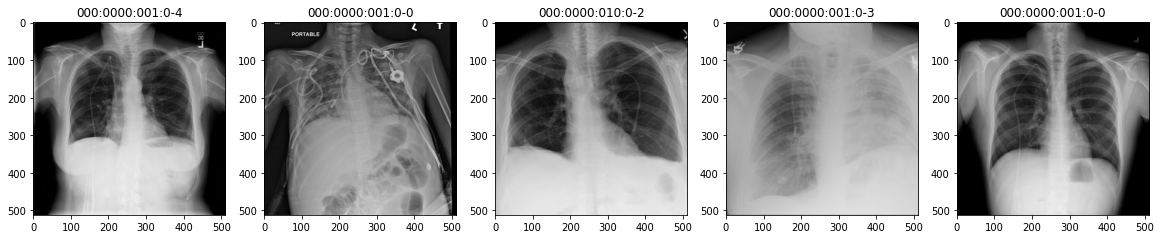

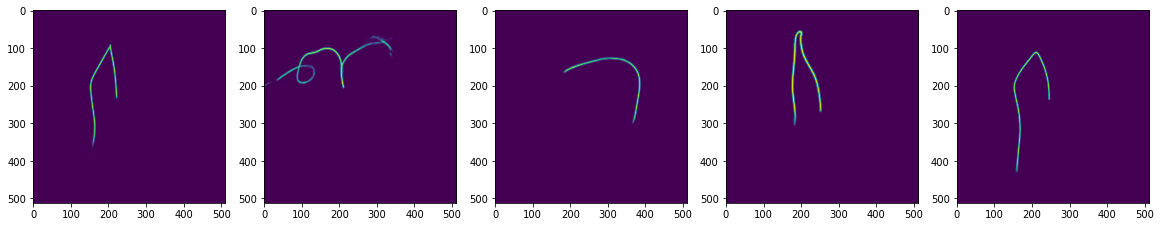

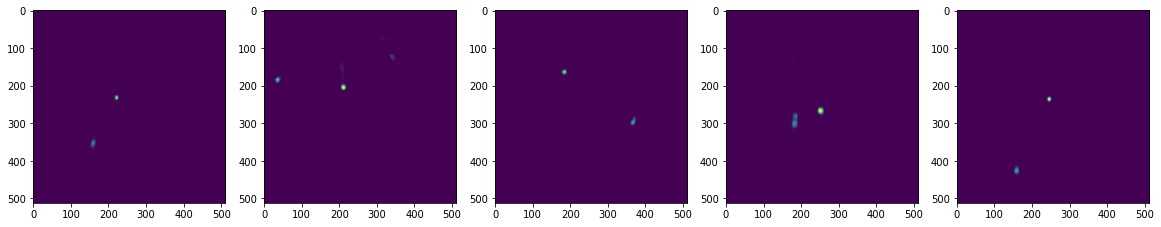

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

f, axarr = plt.subplots(1,5)
masks = []
gen_ds_iter = iter(gen_ds)
for p in range(5):
    img, mask, labels, fold = next(gen_ds_iter)
    axarr[p].imshow(img)
    title = "{0}{1}{2}:{3}{4}{5}{6}:{7}{8}{9}:{10}-{11}".format(
        labels[0], labels[1], labels[2],
        labels[3], labels[4], labels[5], labels[6],
        labels[7], labels[8], labels[9], labels[10],
        fold)
    axarr[p].set_title(title)
    masks.append(mask)

f, axarr = plt.subplots(1,5)
for p in range(5):
    axarr[p].imshow(masks[p][ : , : , 0])

f, axarr = plt.subplots(1,5)
for p in range(5):
    axarr[p].imshow(masks[p][ : , : , 1])